## COMPOUND V2 WALLET SCORING

###  PROBLEM OVERVIEW  
Zeru Finance is building an AI-powered, decentralized credit scoring system. You are provided with raw, transaction-level data from the Compound V2 protocol. Each record corresponds to a wallet interacting with the protocol through actions such as deposit, borrow, repay, withdraw, and liquidation.

Your task is to develop a machine learning model that assigns a credit score between 0 and 100 to each wallet, based solely on historical transaction behavior. Higher scores indicate reliable and responsible usage; lower scores reflect risky, bot-like, or exploitative behavior.

### 1. LOADING THE DATA

In [12]:
import pandas as pd
import json 
import os 
import time 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

file_paths = [
    'compoundV2_transactions_ethereum_chunk_0.json',
    'compoundV2_transactions_ethereum_chunk_1.json',
    'compoundV2_transactions_ethereum_chunk_2.json'
]



### 1.1 PREPROCESSING THE DATASET

In [13]:

def get_standard_event_name(event_key_from_json):
    
    if event_key_from_json.lower() == 'deposits':
        return 'Supply'

    return event_key_from_json.capitalize()

all_dataframes = []
start_time = time.time()

print("Starting data loading process")

for file_path in file_paths:
    print(f"\nProcessing file: {file_path}")
    if not os.path.exists(file_path):
        print(f"-> File not found: {file_path}. Skipping.")
        continue 

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

   
    event_key = 'deposits' 
    if event_key in data and isinstance(data[event_key], list) and data[event_key]:
        records = data[event_key]
        event_name = get_standard_event_name(event_key) 
        print(f"-> Found {len(records)} records under key '{event_key}' (standardized as '{event_name}'). Normalizing...")

        
        df = pd.json_normalize(records)

        # --- Column Mapping 
        column_mapping = {
            'wallet': ['account.id'],
            'amount': ['amount'],      
            'symbol': ['asset.symbol'],
            'timestamp': ['timestamp'], 
            'tx_hash': ['hash'],      
            'token_address': ['asset.id'] 
        }

     
        df_selected = pd.DataFrame()
        processed_cols = set()
        for target_col, source_cols in column_mapping.items():
            for source_col in source_cols:
                
                if source_col in df.columns and target_col not in processed_cols:
                    df_selected[target_col] = df[source_col]
                    processed_cols.add(target_col)
                    break

        df_selected['event_name'] = event_name
        processed_cols.add('event_name')

        # Check essential columns (will raise error if column missing earlier)
        essential_cols = ['wallet', 'amount', 'symbol', 'timestamp', 'tx_hash', 'event_name']
        # Optional: Keep this check just to be safe before final selection? Or remove? Let's keep it as a warning.
        current_cols = df_selected.columns.tolist()
        missing_essential = [col for col in essential_cols if col not in current_cols]
        if missing_essential:
             # This condition might be less likely now without error handling before it
             print(f"POST-PROCESSING WARNING: Missing essential columns {missing_essential} for event key '{event_key}'.")
             

        final_columns_to_keep = essential_cols + ['token_address'] if 'token_address' in current_cols else essential_cols
        df_final = df_selected[final_columns_to_keep].copy()

        all_dataframes.append(df_final)
        print(f"Successfully processed {len(df_final)} records from key '{event_key}'.")

    else:
        print(f"Key '{event_key}' not found, not a list, or empty in {file_path}.")

   


if all_dataframes:
    print(f"\nConcatenating {len(all_dataframes)} dataframes (ONLY 'Supply' events)...")
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"-> Initial combined dataframe shape: {combined_df.shape}")

    print("\nPerforming initial cleaning and type conversion...")
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], unit='s', errors='coerce')
    combined_df['amount'] = pd.to_numeric(combined_df['amount'], errors='coerce')
    combined_df['wallet'] = combined_df['wallet'].astype(str)
    combined_df['symbol'] = combined_df['symbol'].astype(str)
    combined_df['event_name'] = combined_df['event_name'].astype(str)
    combined_df['tx_hash'] = combined_df['tx_hash'].astype(str)
    if 'token_address' in combined_df.columns:
       combined_df['token_address'] = combined_df['token_address'].astype(str)

    initial_rows = len(combined_df)
    critical_cols = ['wallet', 'timestamp', 'amount', 'event_name', 'symbol', 'tx_hash']
    combined_df.dropna(subset=critical_cols, inplace=True)
    rows_dropped = initial_rows - len(combined_df)
    if rows_dropped > 0:
        print(f"-> Dropped {rows_dropped} rows due to missing critical information.")

    combined_df.sort_values(by='timestamp', inplace=True)
    combined_df.reset_index(drop=True, inplace=True)

    end_time = time.time()
    print(f"\n--- Data Loading Complete (Loaded ONLY Supply/Deposit Data) ---")
    print(f"Total time taken: {end_time - start_time:.2f} seconds")
    print(f"Final combined dataframe shape: {combined_df.shape}")
    print("\nDataFrame Info:")
    combined_df.info(memory_usage='deep')
    print("\nDataFrame Head:")
    print(combined_df.head())
    print("\nUnique Event Types Loaded:")
    print(combined_df['event_name'].value_counts()) # Should only show 'Supply'

    

else:
    print("\nNo dataframes were successfully loaded. Please check file paths, JSON format, and the assumption that the key 'deposits' exists.")

Starting data loading process

Processing file: compoundV2_transactions_ethereum_chunk_0.json
-> Found 10000 records under key 'deposits' (standardized as 'Supply'). Normalizing...
Successfully processed 10000 records from key 'deposits'.

Processing file: compoundV2_transactions_ethereum_chunk_1.json
-> Found 10000 records under key 'deposits' (standardized as 'Supply'). Normalizing...
Successfully processed 10000 records from key 'deposits'.

Processing file: compoundV2_transactions_ethereum_chunk_2.json
-> Found 10000 records under key 'deposits' (standardized as 'Supply'). Normalizing...
Successfully processed 10000 records from key 'deposits'.

Concatenating 3 dataframes (ONLY 'Supply' events)...
-> Initial combined dataframe shape: (30000, 7)

Performing initial cleaning and type conversion...


C:\Users\addys\AppData\Local\Temp\ipykernel_17180\630536142.py:84: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], unit='s', errors='coerce')



--- Data Loading Complete (Loaded ONLY Supply/Deposit Data) ---
Total time taken: 2.12 seconds
Final combined dataframe shape: (30000, 7)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wallet         30000 non-null  object        
 1   amount         30000 non-null  float64       
 2   symbol         30000 non-null  object        
 3   timestamp      30000 non-null  datetime64[ns]
 4   tx_hash        30000 non-null  object        
 5   event_name     30000 non-null  object        
 6   token_address  30000 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 12.0 MB

DataFrame Head:
                                       wallet        amount symbol  \
0  0x502cb8985b2c92a8d4bf309cdaa89de9be442708  1.000000e+16    ETH   
1  0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f  8.

### 1.3 VISUALIZING THE RAW DATA

Plotting daily supply transaction volume...


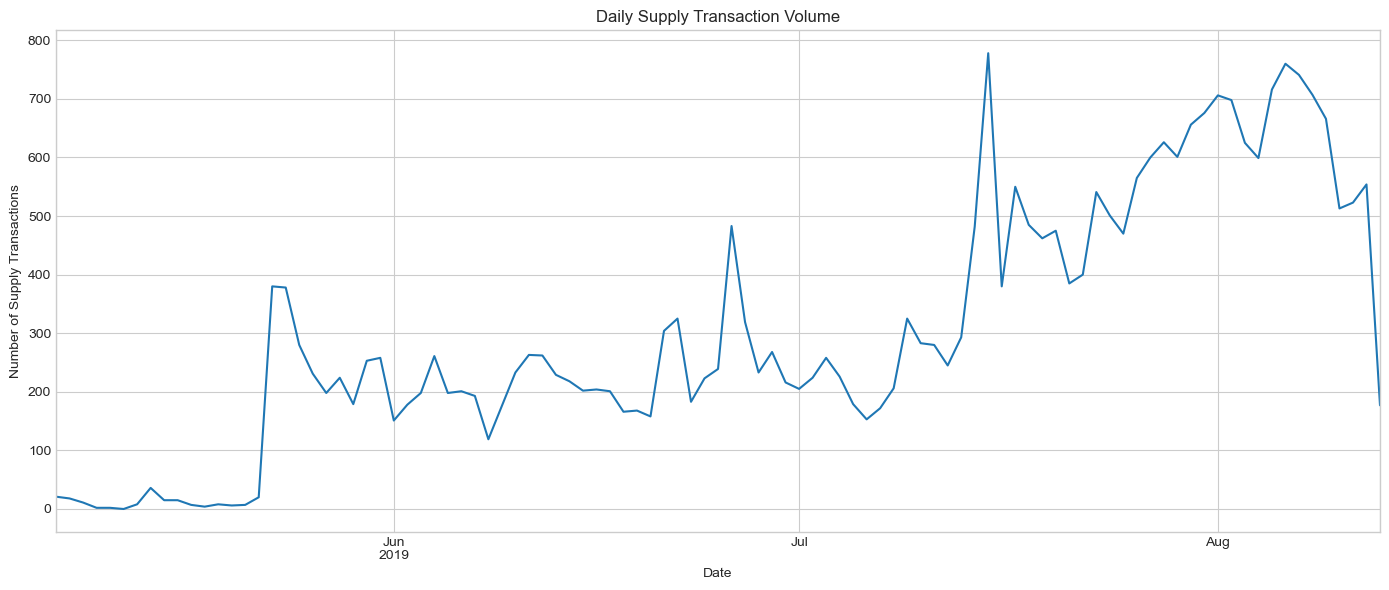


Plotting top supplied assets by transaction count...


C:\Users\addys\AppData\Local\Temp\ipykernel_17180\2075562007.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=asset_counts.head(top_n).values, y=asset_counts.head(top_n).index, palette='viridis')


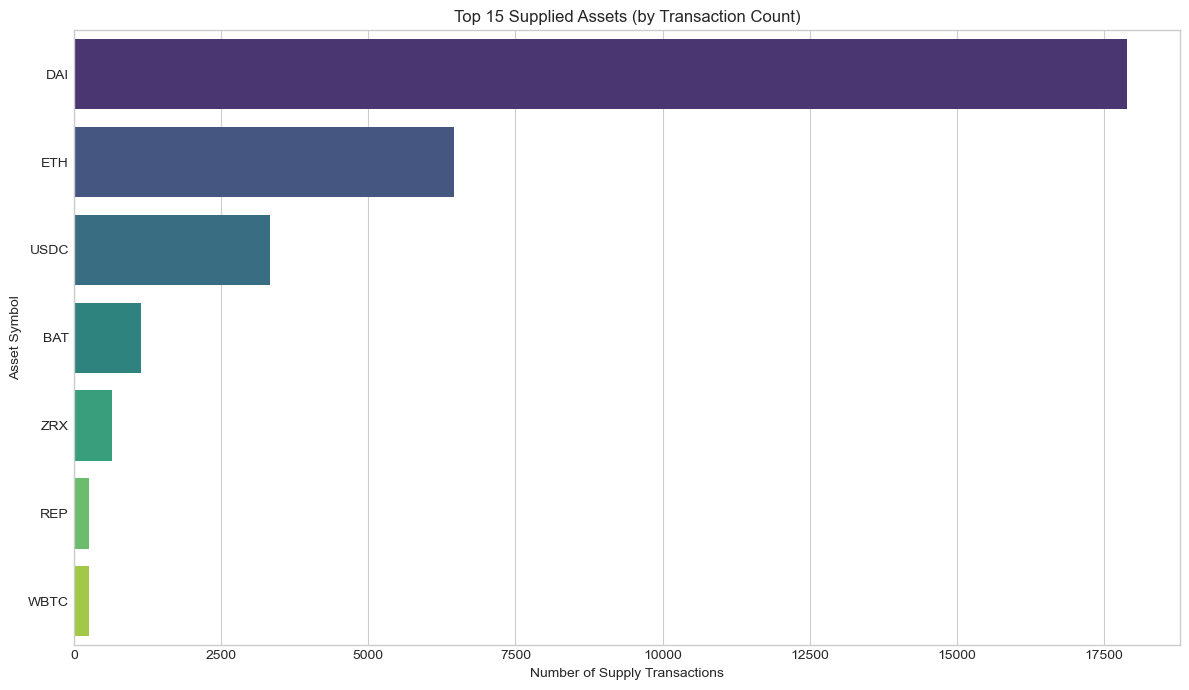


Raw Data Visualization Complete


In [14]:


#Transaction Volume Over Time
print("Plotting daily supply transaction volume...")
daily_counts = combined_df.set_index('timestamp').resample('D').size() # Count transactions per day
plt.figure(figsize=(14, 6))
daily_counts.plot()
plt.title('Daily Supply Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Supply Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

#Top Supplied Assets
print("\nPlotting top supplied assets by transaction count...")
top_n = 15 # Show top 15 assets
asset_counts = combined_df['symbol'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=asset_counts.head(top_n).values, y=asset_counts.head(top_n).index, palette='viridis')
plt.title(f'Top {top_n} Supplied Assets (by Transaction Count)')
plt.xlabel('Number of Supply Transactions')
plt.ylabel('Asset Symbol')
plt.tight_layout()
plt.show()

print("\nRaw Data Visualization Complete")




### 2. FEATURE ENGINEERING

In [15]:
import pandas as pd
import numpy as np
import time


# Columns: ['wallet', 'amount', 'symbol', 'timestamp', 'tx_hash', 'event_name', 'token_address']

print("\n--- Starting Improved Feature Engineering (Supplier Focused) ---")
start_fe_time = time.time()


SUPPLY_EVENT = 'Supply'
epsilon = 1e-6 # Small constant to avoid division by zero


print("Step 0: Calculating overall latest timestamp...")
overall_max_timestamp = combined_df['timestamp'].max()
print(f"-> Overall latest timestamp in data: {overall_max_timestamp}")



print("Step 1: Performing enhanced initial aggregation by wallet...")

aggregations = {
    'timestamp': ['min', 'max', 'size'], # First supply, last supply, total supply count
    'symbol': ['nunique'],              # Total distinct assets supplied
    'amount': ['mean', 'std', 'sum'],   # Average, std dev, and total amount supplied (raw sum, handle with care)
    'tx_hash': ['nunique']              # Unique transactions (supplies)
}

wallet_grouped = combined_df.groupby('wallet')
wallet_features = wallet_grouped.agg(aggregations)


wallet_features.columns = ['_'.join(col).strip('_') for col in wallet_features.columns.values]


wallet_features.rename(columns={
    'timestamp_min': 'first_supply_timestamp',
    'timestamp_max': 'last_supply_timestamp',
    'timestamp_size': 'supply_count',
    'symbol_nunique': 'distinct_supplied_assets',
    'amount_mean': 'avg_supply_amount_raw', # Raw average amount across potentially different tokens
    'amount_std': 'std_dev_supply_amount_raw', # Raw std dev
    'amount_sum': 'total_supply_amount_raw', # Raw total sum
    'tx_hash_nunique': 'distinct_supply_tx_count' # Often similar to supply_count
}, inplace=True)


wallet_features['total_tx_count'] = wallet_features['supply_count']

# Fill NaN in std dev (happens for wallets with only 1 supply) with 0
wallet_features['std_dev_supply_amount_raw'].fillna(0, inplace=True)

print(f"-> Initial aggregation complete. Found {len(wallet_features)} unique supplier wallets.")




print("Step 2: Calculating derived supplier features...")


first_ts_numeric = pd.to_datetime(wallet_features['first_supply_timestamp']).astype(np.int64) // 10**9
last_ts_numeric = pd.to_datetime(wallet_features['last_supply_timestamp']).astype(np.int64) // 10**9
wallet_features['supplier_activity_duration_seconds'] = last_ts_numeric - first_ts_numeric
wallet_features['supplier_activity_duration_days'] = wallet_features['supplier_activity_duration_seconds'] / (60 * 60 * 24)



wallet_features['avg_time_between_supplies_days'] = np.where(
    wallet_features['supply_count'] > 1,
    wallet_features['supplier_activity_duration_days'] / (wallet_features['supply_count'] - 1),
    0 # Assign 0 for single-supply wallets (no time between supplies)
)


wallet_features['supplies_per_day'] = wallet_features['supply_count'] / (wallet_features['supplier_activity_duration_days'] + epsilon)


wallet_features['days_since_last_supply'] = (overall_max_timestamp - wallet_features['last_supply_timestamp']).dt.total_seconds() / (60 * 60 * 24)


wallet_features['cv_supply_amount_raw'] = wallet_features['std_dev_supply_amount_raw'] / (wallet_features['avg_supply_amount_raw'] + epsilon)

print("-> Derived supplier features calculated.")



print("Step 3: Finalizing supplier features...")

# Select final features relevant for supplier profiling, dropping intermediates if needed
# Decided to keep the raw amount stats but focus interpretation on CV
features_to_keep = [
 
    'supply_count',
    'supplier_activity_duration_days',
    'avg_time_between_supplies_days',
    'supplies_per_day',         # Intensity
    'days_since_last_supply',   # Recency
   
    'distinct_supplied_assets',
    
    'avg_supply_amount_raw',
    'total_supply_amount_raw',
    'cv_supply_amount_raw'     
]
# Ensure all selected features exist
features_to_keep = [f for f in features_to_keep if f in wallet_features.columns]
wallet_features_final = wallet_features[features_to_keep].copy()

# Ensure all features are numeric and handle potential NaNs/Infs
wallet_features_final.replace([np.inf, -np.inf], np.nan, inplace=True)

wallet_features_final.fillna(0, inplace=True)


end_fe_time = time.time()
print(f"\n--- Improved Feature Engineering Complete (Supplier Focused) ---")
print(f"Total time taken: {end_fe_time - start_fe_time:.2f} seconds")
print(f"Final supplier features shape: {wallet_features_final.shape}")
print("\nSupplier Features DataFrame Info:")
wallet_features_final.info(memory_usage='deep')
print("\nSupplier Features Head (First 5 Rows):")

with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
    print(wallet_features_final.head())
print("\nSupplier Features Description (Statistics):")
with pd.option_context('display.float_format', '{:,.2f}'.format): # Format floats nicely
    print(wallet_features_final.describe())




--- Starting Improved Feature Engineering (Supplier Focused) ---
Step 0: Calculating overall latest timestamp...
-> Overall latest timestamp in data: 2019-08-13 08:30:16
Step 1: Performing enhanced initial aggregation by wallet...
-> Initial aggregation complete. Found 8202 unique supplier wallets.
Step 2: Calculating derived supplier features...
-> Derived supplier features calculated.
Step 3: Finalizing supplier features...

--- Improved Feature Engineering Complete (Supplier Focused) ---
Total time taken: 0.11 seconds
Final supplier features shape: (8202, 9)

Supplier Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8202 entries, 0x000000aaee6a496aaf7b7452518781786313400f to 0xfff95dea424c0d7a25471982610a2485f302fb54
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   supply_count                     8202 non-null   int64  
 1   supplier_activity_duratio

C:\Users\addys\AppData\Local\Temp\ipykernel_17180\2407183489.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wallet_features['std_dev_supply_amount_raw'].fillna(0, inplace=True)


### 2.2 PLOTTING THE DATA 

Plotting engineered feature distributions...


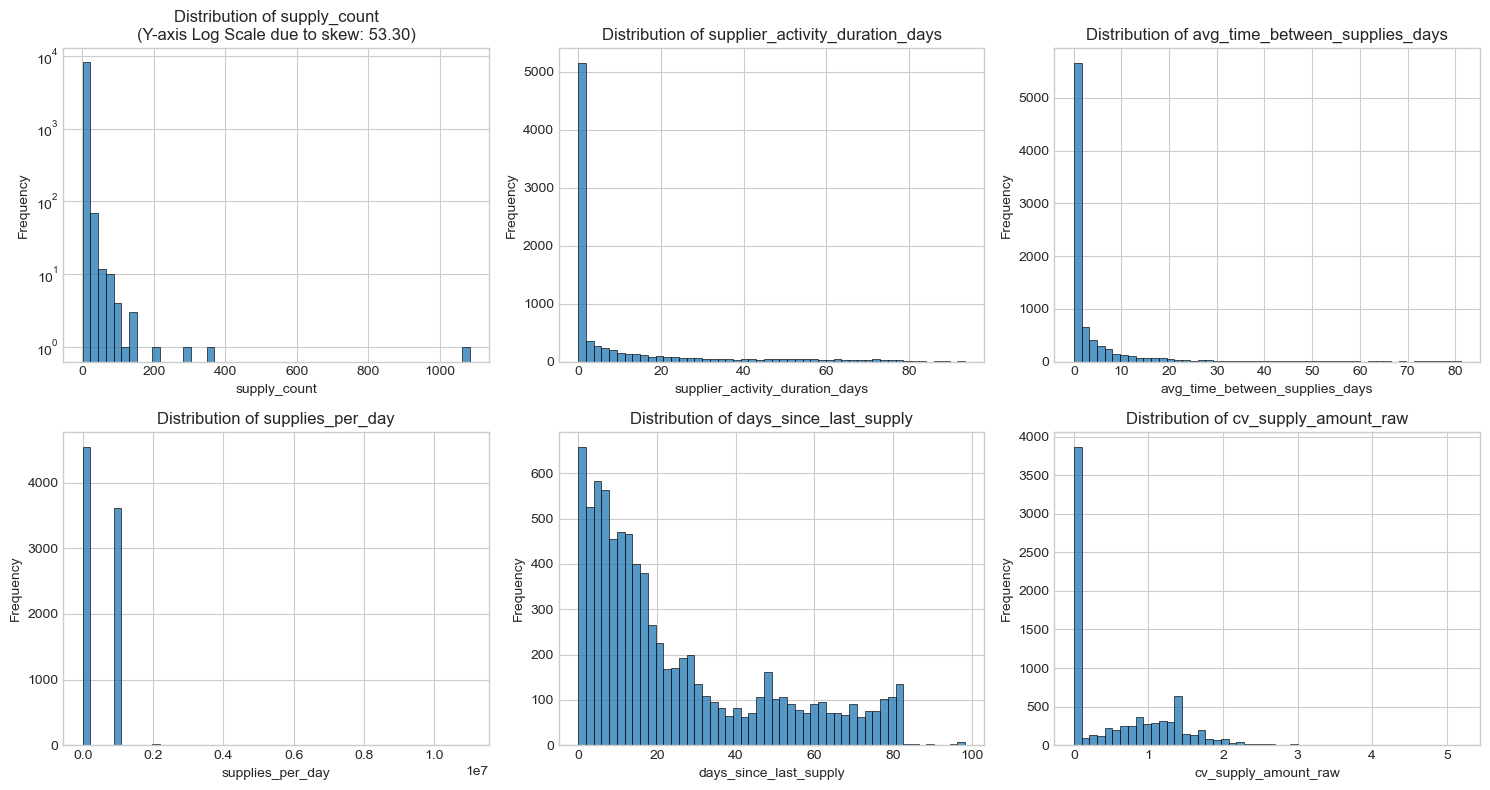


Plotting box plots for outlier detection...


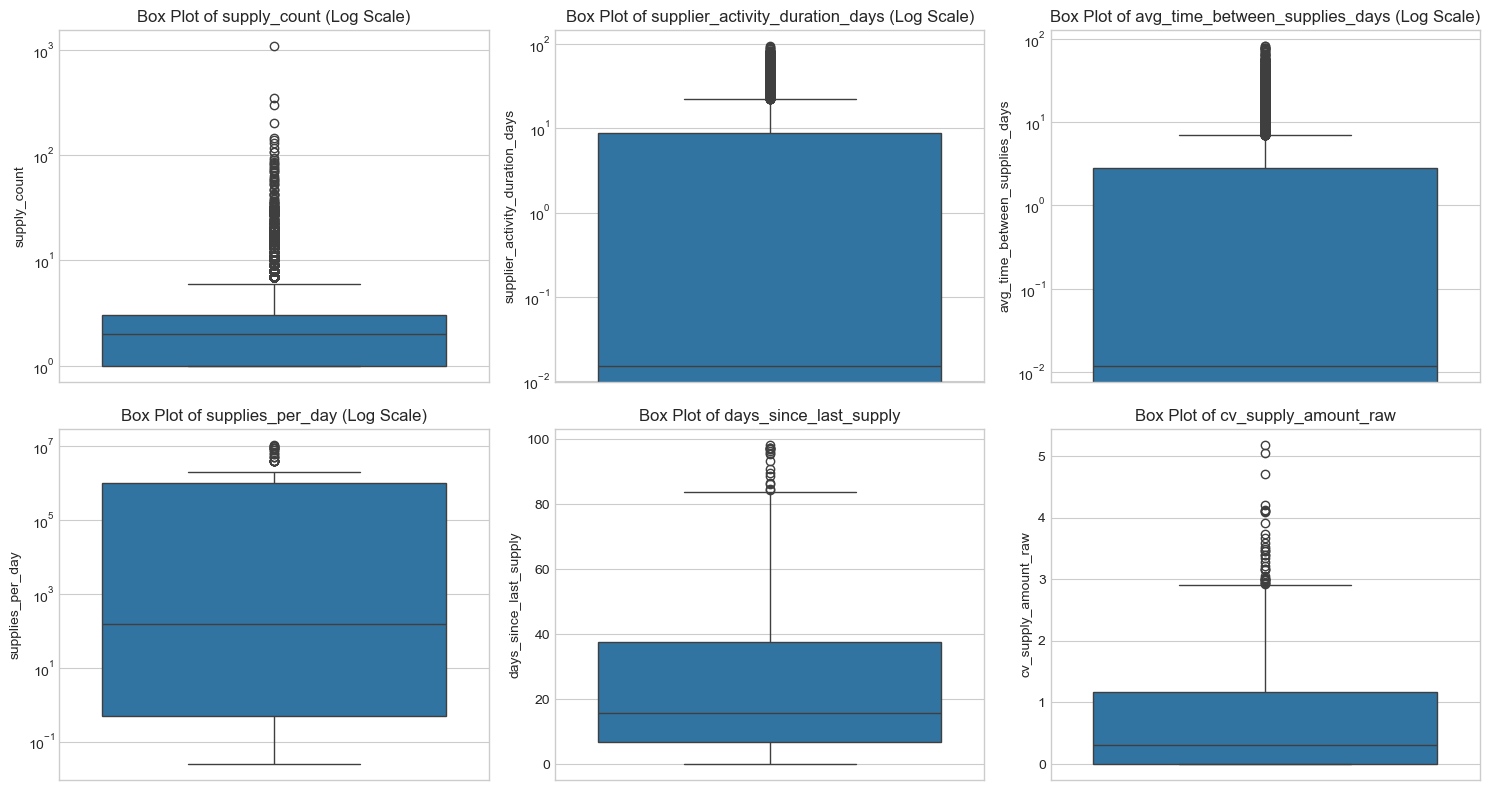


Calculating and plotting feature correlation heatmap...


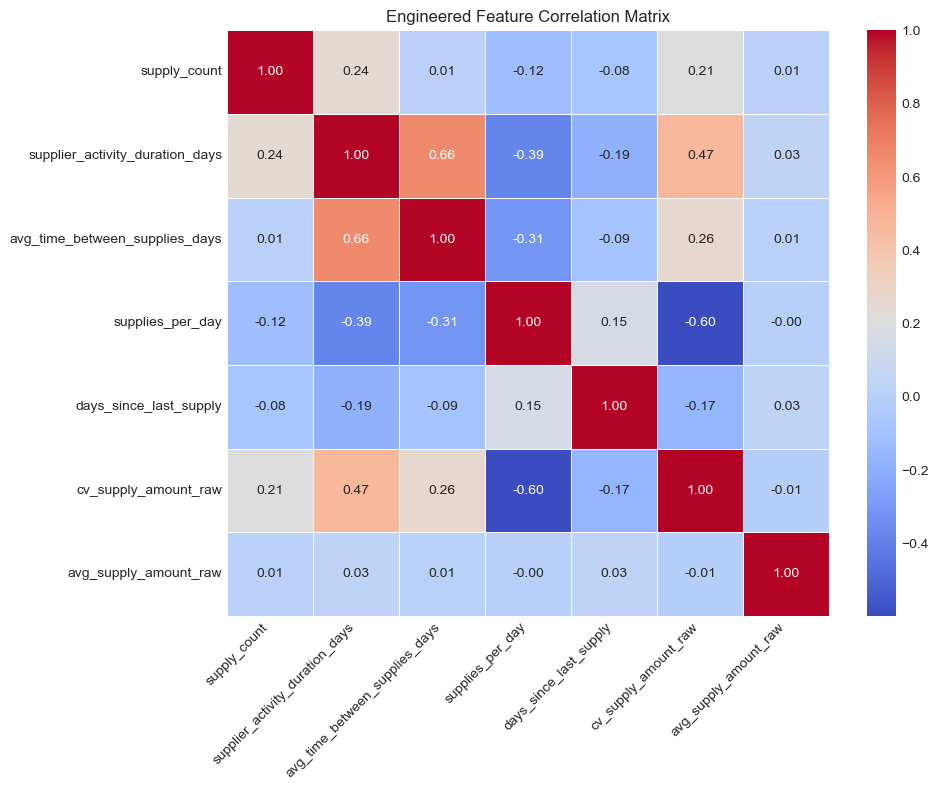

Explained variance ratio by PC1: 0.319
Explained variance ratio by PC2: 0.186
Total variance explained by 2 PCs: 0.505


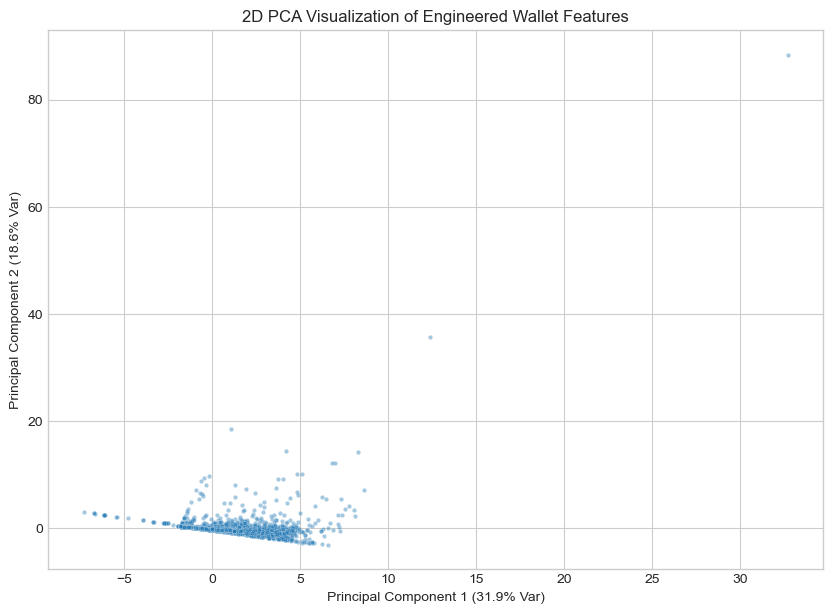

PCA plot generated. Look for visual clusters or patterns.


In [16]:
print("Plotting engineered feature distributions...")


features_to_plot = [
    'supply_count',
    'supplier_activity_duration_days',
    'avg_time_between_supplies_days',
    'supplies_per_day',               
    'days_since_last_supply',       
    'cv_supply_amount_raw'            
    
]
features_to_plot = [f for f in features_to_plot if f in wallet_features_final.columns]

n_features = len(features_to_plot)
n_cols = 3 # Adjust layout if needed
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # Replace infinite values with NaN just for plotting, if any snuck through fillna(0)
    plot_data = wallet_features_final[feature].replace([np.inf, -np.inf], np.nan)
    sns.histplot(plot_data.dropna(), kde=False, ax=axes[i], bins=50) # Use more bins for potentially large ranges

    # Check skewness for log scale decision
    # Need to handle potential negative values (like duration before fixing) if calculating skewness
    skewness = pd.to_numeric(plot_data, errors='coerce').dropna().skew()
    if skewness > 5: # Apply log scale more readily
         try: # Log scale only works for positive data
             axes[i].set_yscale('log') # Log scale on Y axis often better for counts
             axes[i].set_title(f'Distribution of {feature}\n(Y-axis Log Scale due to skew: {skewness:.2f})')
         except: # If data has zeros or negatives, can't use log scale easily
             axes[i].set_title(f'Distribution of {feature}\n(High Skew: {skewness:.2f})')
    else:
         axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)): fig.delaxes(axes[j]) # Hide unused
plt.tight_layout()
plt.show()



print("\nPlotting box plots for outlier detection...")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=wallet_features_final, y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_ylabel(feature)
    # Simple check for using log scale on Y-axis if max is much larger than 75th percentile
    q75 = wallet_features_final[feature].quantile(0.75)
    max_val = wallet_features_final[feature].max()
    if max_val > q75 * 10 and q75 > 0: 
        try:
            axes[i].set_yscale('log')
            axes[i].set_title(f'Box Plot of {feature} (Log Scale)')
        except:
             axes[i].set_title(f'Box Plot of {feature}')


for j in range(i + 1, len(axes)): fig.delaxes(axes[j]) # Hide unused
plt.tight_layout()
plt.show()


print("\nCalculating and plotting feature correlation heatmap...")

correlation_features = features_to_plot + ['avg_supply_amount_raw'] # Add avg amount back for correlation check
correlation_features = [f for f in correlation_features if f in wallet_features_final.columns]
correlation_matrix = wallet_features_final[correlation_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Engineered Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



pca_scaler = StandardScaler()

features_scaled_for_pca = pca_scaler.fit_transform(wallet_features_final)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled_for_pca)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=wallet_features_final.index)

print(f"Explained variance ratio by PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Explained variance ratio by PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total variance explained by 2 PCs: {pca.explained_variance_ratio_.sum():.3f}")

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.4, s=10) # Adjust alpha/size for density
plt.title('2D PCA Visualization of Engineered Wallet Features')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Var)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Var)')
plt.grid(True)
plt.show()
print("PCA plot generated. Look for visual clusters or patterns.")




### 3. MACHINE LEARNING MODEL

Scaled features shape: (8202, 9)
 Determining Optimal K (Elbow Method)
Inertia calculation complete for K=1 to 10.


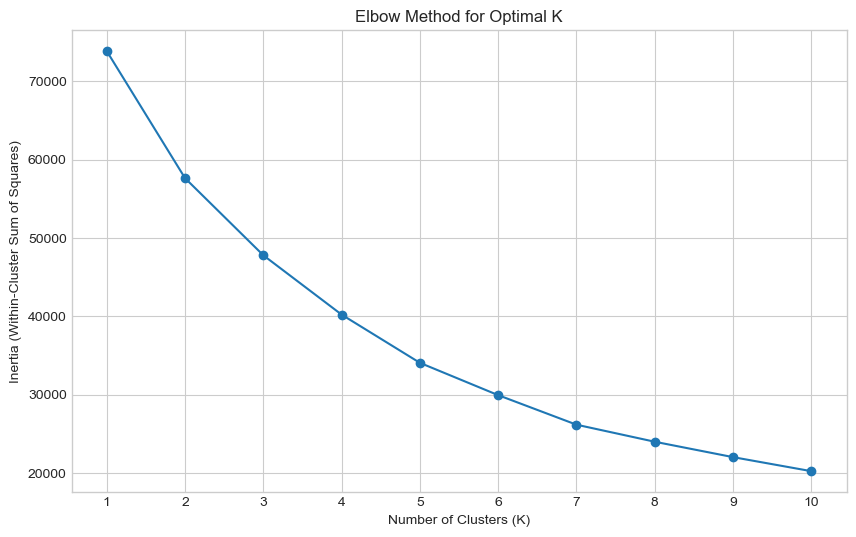


Selected K = 4 based on Elbow method analysis.
Applying K-Means with K=4 
K-Means clustering complete. Wallets assigned to 4 clusters.
Cluster distribution:
cluster
0    1039
1    3805
2    3357
3       1
Name: count, dtype: int64

Analyzing Cluster Centers (Centroids) 
Cluster Centroids (approximate mean feature values for each cluster):
         supply_count  supplier_activity_duration_days  avg_time_between_supplies_days  supplies_per_day  days_since_last_supply  distinct_supplied_assets             avg_supply_amount_raw               total_supply_amount_raw  cv_supply_amount_raw
Cluster                                                                                                                                                                                                                                                 
0               10.27                            51.21                           16.10              0.20                   15.63                      2.13  4,58

In [17]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans




wallet_index = wallet_features_final.index

#  only the numeric features for scaling 
features_to_scale = wallet_features_final.columns
scaler = StandardScaler()
#  scaling
wallet_features_scaled = scaler.fit_transform(wallet_features_final)

print("Scaled features shape:", wallet_features_scaled.shape)


#Determining Optimal K using Elbow Method
print(" Determining Optimal K (Elbow Method)")

inertia = []
possible_k_values = range(1, 11) # Check K from 1 to 10


for k in possible_k_values:
   
    kmeans_temp = KMeans(n_clusters=k,
                         init='k-means++', 
                         n_init=10,      
                         max_iter=300,   
                         random_state=42) 
    kmeans_temp.fit(wallet_features_scaled)
    inertia.append(kmeans_temp.inertia_)
print("Inertia calculation complete for K=1 to 10.")

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(possible_k_values)
plt.grid(True)
plt.show()




chosen_k=4
print(f"\nSelected K = {chosen_k} based on Elbow method analysis.")
print(f"Applying K-Means with K={chosen_k} ")

kmeans = KMeans(n_clusters=chosen_k,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=42)

# Fitting the model and predict cluster labels using the SCALED data
cluster_labels = kmeans.fit_predict(wallet_features_scaled)

# Adding the cluster labels back to the original (unscaled) feature DataFrame for interpretation
wallet_features_final['cluster'] = cluster_labels

print(f"K-Means clustering complete. Wallets assigned to {chosen_k} clusters.")
print("Cluster distribution:")

print(wallet_features_final['cluster'].value_counts().sort_index())



print("\nAnalyzing Cluster Centers (Centroids) ")


centroids_scaled = kmeans.cluster_centers_

# Inverse transform the centroids to understand them in the original feature value space
centroids_original = scaler.inverse_transform(centroids_scaled)

# Creating a DataFrame for easier viewing of original feature values per cluster
centroid_df = pd.DataFrame(centroids_original, columns=features_to_scale)
centroid_df.index.name = 'Cluster'

print("Cluster Centroids (approximate mean feature values for each cluster):")

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.float_format', '{:,.2f}'.format):
    print(centroid_df)



 ### 3.1 SILHOUETTER SCORE AND VISUALIZATION


--- Calculating Silhouette Scores ---
For K = 2, the average Silhouette Score is: 0.3517
For K = 3, the average Silhouette Score is: 0.3533
For K = 4, the average Silhouette Score is: 0.3653
For K = 5, the average Silhouette Score is: 0.3723
For K = 6, the average Silhouette Score is: 0.3867
For K = 7, the average Silhouette Score is: 0.4135
For K = 8, the average Silhouette Score is: 0.4115
For K = 9, the average Silhouette Score is: 0.4191
For K = 10, the average Silhouette Score is: 0.4218


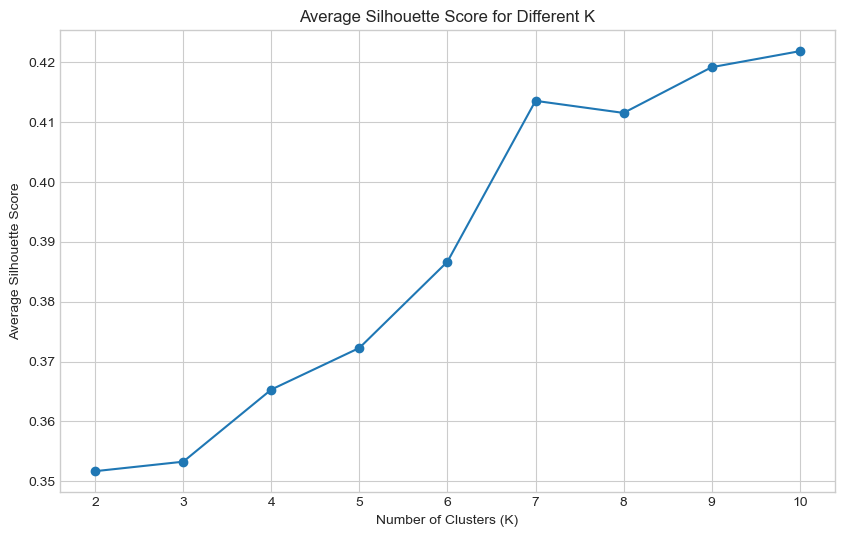

In [18]:


from sklearn.metrics import silhouette_score

print("\n--- Calculating Silhouette Scores ---")

silhouette_scores = []
#  from K=2 because Silhouette Score requires at least 2 clusters
possible_k_values_sil = range(2, 11)

for k in possible_k_values_sil:
   
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    cluster_labels_temp = kmeans_temp.fit_predict(wallet_features_scaled) # Use SCALED data

    # Calculate Silhouette Score
   
    silhouette_avg = silhouette_score(wallet_features_scaled, cluster_labels_temp)
    silhouette_scores.append(silhouette_avg)
    print(f"For K = {k}, the average Silhouette Score is: {silhouette_avg:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(possible_k_values_sil, silhouette_scores, marker='o')
plt.title('Average Silhouette Score for Different K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.xticks(possible_k_values_sil)
plt.grid(True)
plt.show()





### 4. CUSTOM SCORING LOGIC BASED ON CLUSTER ANALYSIS

In [19]:




cluster_ranking = {
    1: 0,  # Rank 0
    3: 1,  # Rank 1
    2: 2,  # Rank 2
    0: 3   # Rank 3
}

print("Cluster Ranking (0=Worst, 3=Best):")
ranked_clusters_display = sorted(cluster_ranking.items(), key=lambda item: item[1])
for cluster_label, rank in ranked_clusters_display:
    print(f"  Cluster {cluster_label}: Rank {rank}")

# Assigning base score ranges (0-25, 25-50, 50-75, 75-100)
num_ranks = len(cluster_ranking) 
score_ranges = {}
range_size = 100 / num_ranks 

print("\nAssigning Base Score Ranges per Cluster Rank:")
for cluster_label, rank in cluster_ranking.items():
    min_score = rank * range_size
    max_score = (rank + 1) * range_size
  
    if rank == num_ranks - 1: max_score = 100.0
    if rank == 0: min_score = 0.0
    score_ranges[cluster_label] = (min_score, max_score)
    print(f"  Cluster {cluster_label} (Rank {rank}): Score Range {min_score:.2f} - {max_score:.2f}")




refining_feature = 'supplier_activity_duration_days'
print(f"\nUsing feature '{refining_feature}' for intra-cluster score refinement.")

# Adding a new 'score' column, initialize with NaN
wallet_features_final['score'] = np.nan

print("Calculating final scores...")
# Iterating through each cluster defined in our ranking
for cluster_label, (min_score, max_score) in score_ranges.items():
    # Creating a boolean mask to select rows belonging to the current cluster
    cluster_mask = (wallet_features_final['cluster'] == cluster_label)

    # Checking if the cluster has any members
    num_members = cluster_mask.sum()
    if num_members == 0:
        print(f"  Cluster {cluster_label} has no members. Skipping.")
        continue
    print(f"  Processing Cluster {cluster_label} ({num_members} members)...")

    # Getting the refining feature values ONLY for wallets in this cluster
    cluster_feature_values = wallet_features_final.loc[cluster_mask, refining_feature]

    # --- Min-Max Scale the refining feature WITHIN this cluster (0 to 1 range) ---
    min_val = cluster_feature_values.min()
    max_val = cluster_feature_values.max()

    # Handling edge case: single member cluster (like Cluster 3) or constant feature value
    if max_val == min_val:
        # Assigning the midpoint score factor if no variation (or only one member)
        scaled_feature = 0.5
        # print(f"  Cluster {cluster_label}: Feature '{refining_feature}' is constant. Assigning midpoint score factor.")
    else:
        # Apply Min-Max scaling: (value - min) / (max - min) -> results in 0 to 1 range
        scaled_feature = (cluster_feature_values - min_val) / (max_val - min_val)

    #Mapping the 0-1 scaled feature value to the cluster's score range ---
    # Final Score = Base Min Score + (Scaled Feature * Size of the Range)
    cluster_scores = min_score + scaled_feature * (max_score - min_score)

    # Assigning the calculated scores back to the corresponding rows in the main DataFrame
    wallet_features_final.loc[cluster_mask, 'score'] = cluster_scores
    


# Checking for any remaining NaNs 
if wallet_features_final['score'].isnull().any():
    print(" Some wallets have NaN scores Filling with 0.")
    wallet_features_final['score'].fillna(0, inplace=True)

# Ensuring scores are strictly within the 0-100 bound (safety clip)
wallet_features_final['score'] = wallet_features_final['score'].clip(0, 100)

# Rounding the scores for cleaner output
wallet_features_final['score'] = wallet_features_final['score'].round(2)

print("\n--- Scoring Complete ---")
print("Final 'score' column added and populated.")
print("\nScore distribution summary (Overall):")
print(wallet_features_final['score'].describe())
print("\nScore distribution summary (By Cluster):")
# Use describe() to see stats per cluster, verifying the ranges
print(wallet_features_final.groupby('cluster')['score'].describe()) #[['min', '25%', '50%', '75%', 'max']])

# Display head with score
print("\nWallet Features Head with Score:")
with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
    print(wallet_features_final[['cluster', 'score'] + features_to_keep].head()) # Show score and cluster first




Cluster Ranking (0=Worst, 3=Best):
  Cluster 1: Rank 0
  Cluster 3: Rank 1
  Cluster 2: Rank 2
  Cluster 0: Rank 3

Assigning Base Score Ranges per Cluster Rank:
  Cluster 1 (Rank 0): Score Range 0.00 - 25.00
  Cluster 3 (Rank 1): Score Range 25.00 - 50.00
  Cluster 2 (Rank 2): Score Range 50.00 - 75.00
  Cluster 0 (Rank 3): Score Range 75.00 - 100.00

Using feature 'supplier_activity_duration_days' for intra-cluster score refinement.
Calculating final scores...
  Processing Cluster 1 (3805 members)...
  Processing Cluster 3 (1 members)...
  Processing Cluster 2 (3357 members)...
  Processing Cluster 0 (1039 members)...

--- Scoring Complete ---
Final 'score' column added and populated.

Score distribution summary (Overall):
count    8202.000000
mean       33.265852
std        32.804721
min         0.000000
25%         0.000000
50%        50.010000
75%        55.097500
max       100.000000
Name: score, dtype: float64

Score distribution summary (By Cluster):
          count       mean 

In [21]:




scores_df = wallet_features_final[['score']].copy()
scores_df.index.name = 'wallet' # Ensure the index has the name 'wallet'

# Sort by score, descending
scores_df_sorted = scores_df.sort_values(by='score', ascending=False)

# Select top 1000 wallets
top_1000_scores = scores_df_sorted.head(1000)


csv_filename = 'top_1000_wallet_scores.csv'
print(f"\nSaving top 1000 wallet scores to '{csv_filename}'")
top_1000_scores.to_csv(csv_filename)




print("\nIdentifying wallets for analysis")

# Get top 5 wallets (already sorted)
top_5_wallets = top_1000_scores.head(5)
print("\nTop 5 Scoring Wallets:")
print(top_5_wallets)

# Get bottom 5 wallets
# Sort ascending to get the lowest scores overall
scores_df_sorted_asc = scores_df.sort_values(by='score', ascending=True)
bottom_5_wallets = scores_df_sorted_asc.head(5)
print("\nBottom 5 Scoring Wallets:")
print(bottom_5_wallets)

print("\nFetching full feature data for selected wallets...")

# Get feature data for top 5
top_5_features = wallet_features_final.loc[top_5_wallets.index]

# Get feature data for bottom 5
bottom_5_features = wallet_features_final.loc[bottom_5_wallets.index]

# Display features for analysis - print them nicely formatted
print("\nFeatures for Top 5 Wallets")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 120, 'display.float_format', '{:,.2f}'.format):
    print(top_5_features[['cluster', 'score'] + features_to_keep]) # Show cluster and score first

print("\nFeatures for Bottom 5 Wallets")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 120, 'display.float_format', '{:,.2f}'.format):
    print(bottom_5_features[['cluster', 'score'] + features_to_keep])




Saving top 1000 wallet scores to 'top_1000_wallet_scores.csv'

Identifying wallets for analysis

Top 5 Scoring Wallets:
                                             score
wallet                                            
0x0f3c2476fbf0ed09dff00ea7f4ef252dcc72e6f1  100.00
0x4654f56a64301b9b582f843f97332d96ead11ff8   99.54
0x505e20c0fb8252ca7ac21d54d5432eccd4f2d076   98.73
0x6316ff9d2c96b6b122e0dd632ab5831e0bf5bd10   98.16
0xdf0635793e91d4f8e7426dbd9ed08471186f428d   97.89

Bottom 5 Scoring Wallets:
                                            score
wallet                                           
0x8117b86882137689babc18eafad86885171f3553    0.0
0x4fe501984561ac79ec201bf4540e0ced536ab85f    0.0
0x9ef80dd6ecfa7f0c5f5fa528841341d08933fac4    0.0
0x9eefb47db22fea3b03059ef1183cd7a02465e4ec    0.0
0x4ff0ddceda6af4adc3e51bae879aa2ef8accacb3    0.0

Fetching full feature data for selected wallets...

Features for Top 5 Wallets
                                            cluster  score  suppl

analysis

In [22]:
top_wallet_addresses = [
    '0x0f3c2476fbf0ed09dff00ea7f4ef252dcc72e6f1',
    '0x4654f56a64301b9b582f843f97332d96ead11ff8',
    '0x505e20c0fb8252ca7ac21d54d5432eccd4f2d076',
    '0x6316ff9d2c96b6b122e0dd632ab5831e0bf5bd10',
    '0xdf0635793e91d4f8e7426dbd9ed08471186f428d'
]


actual_top_5_features = wallet_features_final.loc[top_wallet_addresses]


print("\n Features for Actual Top 5 Wallets")
features_to_display = ['cluster', 'score', 'supplier_activity_duration_days', 'supply_count', 'supplies_per_day', 'days_since_last_supply', 'distinct_supplied_assets', 'cv_supply_amount_raw']
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 120, 'display.float_format', '{:,.2f}'.format):
    print(actual_top_5_features[features_to_display])


 Features for Actual Top 5 Wallets
                                            cluster  score  supplier_activity_duration_days  supply_count  \
wallet                                                                                                      
0x0f3c2476fbf0ed09dff00ea7f4ef252dcc72e6f1        0 100.00                            93.64            70   
0x4654f56a64301b9b582f843f97332d96ead11ff8        0  99.54                            92.04            91   
0x505e20c0fb8252ca7ac21d54d5432eccd4f2d076        0  98.73                            89.17             9   
0x6316ff9d2c96b6b122e0dd632ab5831e0bf5bd10        0  98.16                            87.19             3   
0xdf0635793e91d4f8e7426dbd9ed08471186f428d        0  97.89                            86.23            37   

                                            supplies_per_day  days_since_last_supply  distinct_supplied_assets  \
wallet                                                                                

In [ ]:


print("\n Features for Actual Bottom 5 Wallets ")


bottom_wallet_addresses = bottom_5_wallets.index.tolist()


actual_bottom_5_features = wallet_features_final.loc[bottom_wallet_addresses]


features_to_display = [
    'cluster',
    'score',
    'supplier_activity_duration_days',
    'supply_count',
    'supplies_per_day',
    'days_since_last_supply',
    'distinct_supplied_assets',
    'cv_supply_amount_raw'
]


with pd.option_context(
    'display.max_rows', None,        
    'display.max_columns', None,     
    'display.width', 120,            
    'display.float_format', '{:,.2f}'.format 
    ):
    print(actual_bottom_5_features[features_to_display])


 Features for Actual Bottom 5 Wallets 
                                            cluster  score  supplier_activity_duration_days  supply_count  \
wallet                                                                                                      
0x8117b86882137689babc18eafad86885171f3553        1   0.00                             0.00             1   
0x4fe501984561ac79ec201bf4540e0ced536ab85f        1   0.00                             0.00             1   
0x9ef80dd6ecfa7f0c5f5fa528841341d08933fac4        1   0.00                             0.00             1   
0x9eefb47db22fea3b03059ef1183cd7a02465e4ec        1   0.00                             0.00             1   
0x4ff0ddceda6af4adc3e51bae879aa2ef8accacb3        1   0.00                             0.00             1   

                                            supplies_per_day  days_since_last_supply  distinct_supplied_assets  \
wallet                                                                            